In [884]:
import cv2
import matplotlib.pyplot as plt
import math
from numpy.linalg import norm,inv,pinv

In [885]:
img0 = cv2.imread("image_glasses.png",0)
img1 = cv2.imread("sample1.jpg",0)
img2 = cv2.imread("sample2.png",0)
img3 = cv2.imread("sample3.jpg",0)
img4 = cv2.imread("sample4.jpg",0)
w = 8

In [886]:
def priority(mask,mask_boundary,gradient):
    max_count = 0
    grad = 100000
    for p in mask_boundary:
        count=0
        val = 0
        for x in range(-w//2,w//2):
            for y in range(-w//2,w//2):
                if not mask[p[0]+x][p[1]+y]:
                    count+=1
                    val+= gradient[p[0]+x][p[1]+y]
        if count>=1:
            max_count = max(max_count,count)
            if max_count==count:
                grad = min(grad,val)
                if grad==val:
                    pixel = p
    print(max_count,grad)
    return pixel

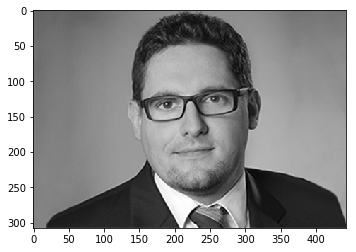

In [887]:
%matplotlib inline
plt.imshow(img0,cmap = 'gray')

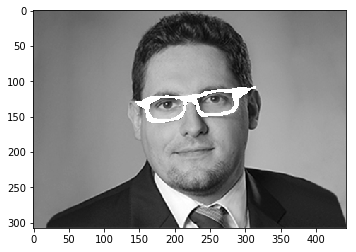

In [888]:
img_masked = cv2.imread("image_no_glasses.png",0)
plt.imshow(img_masked,cmap = 'gray')

In [889]:
import numpy as np
img01 = cv2.resize(img0,(400,300))
img11 = cv2.resize(img1,(400,300))
img21 = cv2.resize(img2,(400,300))
img31 = cv2.resize(img3,(400,300))
img41 = cv2.resize(img4,(400,300))
dict_img = np.concatenate((img01,img11,img21,img31,img41),axis=1)
# plt.imshow(dict_img,cmap = 'gray')

# Dictionary Creation
D1 is 64x128 large dictionary and D2 is 64x256 large dictionary

In [890]:
import random
# initializing the order of selecting the images
seq = random.sample(range(0,5),5)
# print(seq)
D1 = np.ndarray((64,130))
l = 0
k = 0
count = 0
# selecting an 8x8 window around a randomly selected pixel in a randomly selected image and creating a vector
for i in seq:
    x = random.sample(range(25,375,8),26)
    y = random.sample(range(4,295,8),26)
    for c in range(26):
        l=0
        for a in range(-4,4):
            for b in range(-4,4):
                D1[l][k] = dict_img[y[c]+a][x[c]+400*i+b]
                l+=1
                count+=1
        k+=1
# Since 64x128 size dictionary is required, 2 randomly selected columns are deleted
for i in range(2):
    clean = random.randint(0,len(D1))
    D1 = np.delete(D1,clean,1)
# print(len(D[0]))

In [891]:
img02 = cv2.resize(img0,(800,600))
img12 = cv2.resize(img1,(800,600))
img22 = cv2.resize(img2,(800,600))
img32 = cv2.resize(img3,(800,600))
img42 = cv2.resize(img4,(800,600))
dict_img2 = np.concatenate((img02,img12,img22,img32,img42),axis=1)
seq = random.sample(range(0,5),5)
D2 = np.ndarray((64,260))
l = 0
k = 0
count = 0
for i in seq:
    x = random.sample(range(4,775,8),52)
    y = random.sample(range(4,595,8),52)
    for c in range(26):
        l=0
        for a in range(-4,4):
            for b in range(-4,4):
                D2[l][k] = dict_img2[y[c]+a][x[c]+800*i+b]
                l+=1
                count+=1
        k+=1
# Since 64x128 size dictionary is required, 2 randomly selected columns are deleted
for i in range(4):
    clean = random.randint(0,len(D2))
    D2 = np.delete(D2,clean,1)
# print(len(D[0]))

Extracting mask

In [892]:
mask = img_masked
for i in range(len(mask)):
    for j in range(len(mask[0])):
        mask[i][j] = mask[i][j]==255
# plt.imshow(mask,cmap='gray')

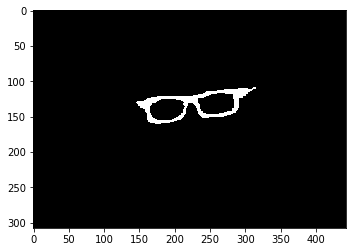

In [893]:
mask_open = cv2.morphologyEx(mask,cv2.MORPH_OPEN,np.ones((2,2),np.uint8))
plt.imshow(mask_open,cmap = 'gray')

Extracting Boundary

In [1]:
mask_boundary = abs(cv2.Laplacian(mask_open,cv2.CV_64F))

plt.imshow(mask_boundary,cmap='gray')

NameError: name 'cv2' is not defined

In [895]:
def pixels(mask_open):
    masked_pixels = []
    for i in range(len(mask_boundary)):
        for j in range(len(mask_boundary[0])):
            if mask_open[i][j]:
                masked_pixels+=[(i,j)]
    return masked_pixels

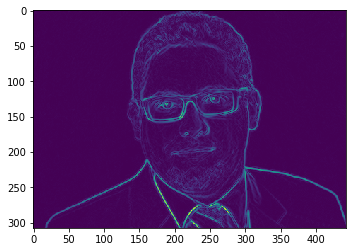

In [896]:
img0_gx = cv2.Sobel(img0,cv2.CV_32F,1,0,ksize=1)
img0_gy = cv2.Sobel(img0,cv2.CV_32F,0,1,ksize=1)
# plt.imshow(img0_gx,cmap='gray')
mag,angle = cv2.cartToPolar(img0_gx,img0_gy,angleInDegrees=True)
plt.imshow(mag)

# Orthogonal Matching Pursuit

In [907]:
def omp(data,dictionary,corrupt):
    coeff = np.zeros((len(dictionary[0]),1))
    data = data/(norm(data))
    for i in range(len(dictionary[0])):
        a = dictionary[:,i]
        dictionary[:,i] = a/norm(a)
    count=0
    res = []
    for k in range(len(data)):
        if k in corrupt:
            continue
        res.append(data[k])
    D = []
    for k in range(len(dictionary)):
        if k in corrupt:
            continue
        D.append(dictionary[k,:])
#         print(k,dictionary[k,:])
    D = np.array(D)
    dat = res
#     print("clean dictionary",D)
    phi=np.ones((len(dat),1))
    k=0
    res = np.array(res)
    insertions = []
    while count<20:
        print(norm(res))
        max_ind = 0
        maximum = -10
        for i in range(len(dictionary[0])):
            a = abs(np.dot(D[:,i],res))
            if a>maximum:
                maximum = a
                max_ind = i
        phi[:,k]=D[:,max_ind]
        D[:,max_ind] = np.zeros((len(D)))
#         print(phi.shape)
#         print(res.shape)
        insertions.append(max_ind)
        c = pinv(phi)
        c = np.matmul(c,dat)
        p=0
        for i in insertions:
            coeff[i] = c[p]
            p+=1
#         print("coeff",coeff)
#         print(np.matmul(phi,c))
#         print(c.shape)
        res = res + np.matmul(phi,c)
#         print(norm(res))
        count+=1
        k+=1
        phi = np.insert(phi,k,1,axis=1)
    return coeff

In [910]:
k=0
pixel = priority(mask_open,pixels(mask_boundary),mag)
x,y = pixel[0],pixel[1]
# print(x,y)
temp = np.ones((64,1))
corrupted = []
for i in range(-w//2,w//2):
    for j in range(-w//2,w//2):
        temp[k] = img0[x+i][y+j]
        if mask_open[x+i][y+j]:
            corrupted.append(k)
        k+=1
print(corrupted)
# print(D1[:,1])
coeff = omp(temp,D1,corrupted)
print(len(coeff))

53 741.156190038
[41, 42, 43, 44, 48, 49, 50, 51, 52, 56, 57, 58, 59, 60]
0.913176620938
1.81746359442
2.72409054991
3.63130442586
4.53891974634
5.44669096496
6.35454896027
7.26251782569
8.17055362417
9.07937327353
9.98854016673
10.8980846866
11.8081020953
12.7184234331
13.6289882105
14.5397509376
15.4507241593
16.3618678965
17.2731621003
18.1845904978
128
